In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply
import plotly.express as px
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
#В качестве выборки предлагается использовать F-score для предсказания целевой переменной - популярности того или иного авто.
#В случае продажи авто нет строгой необходимости уменьшать количество неверно предсказанной популярности. Есть необходимость учитывать как и завышенную популярность авто, так и заниженную, чтобы предсказание было как можно точнее.

In [2]:
pd.set_option('display.max_columns', 20)
df = pd.read_csv("car_stats.csv")
print(df.columns)
print(df.head(5))
print(df.isna().sum())
print(df.describe())
print(df.duplicated())
print(df.dtypes)
print(df["Make"].unique())

Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')
  Make       Model  Year             Engine Fuel Type  Engine HP  \
0  BMW  1 Series M  2011  premium unleaded (required)      335.0   
1  BMW    1 Series  2011  premium unleaded (required)      300.0   
2  BMW    1 Series  2011  premium unleaded (required)      300.0   
3  BMW    1 Series  2011  premium unleaded (required)      230.0   
4  BMW    1 Series  2011  premium unleaded (required)      230.0   

   Engine Cylinders Transmission Type     Driven_Wheels  Number of Doors  \
0               6.0            MANUAL  rear wheel drive              2.0   
1               6.0            MANUAL  rear wheel drive              2.0   
2               6.0            MANUAL  rear wheel drive              2.0   


KeyError: 'Engine_HP'

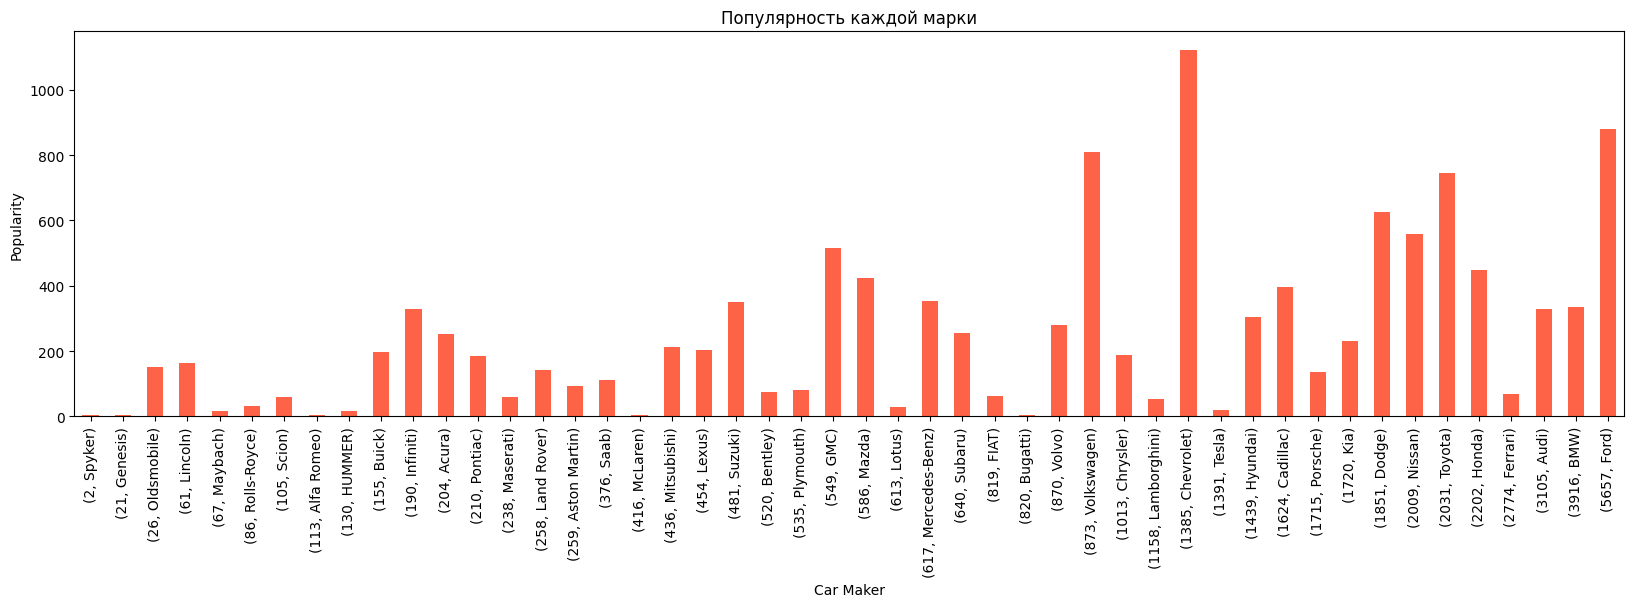

In [4]:

df.groupby('Popularity')['Make'].value_counts().plot(kind="bar", title="Популярность каждой марки",figsize=(20,5), color="tomato")
plt.xlabel('Car Maker')
plt.ylabel('Popularity')
plt.show()
fig1 = px.scatter_matrix(
    df, dimensions=['Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity', 'MSRP']
)
fig1.show()

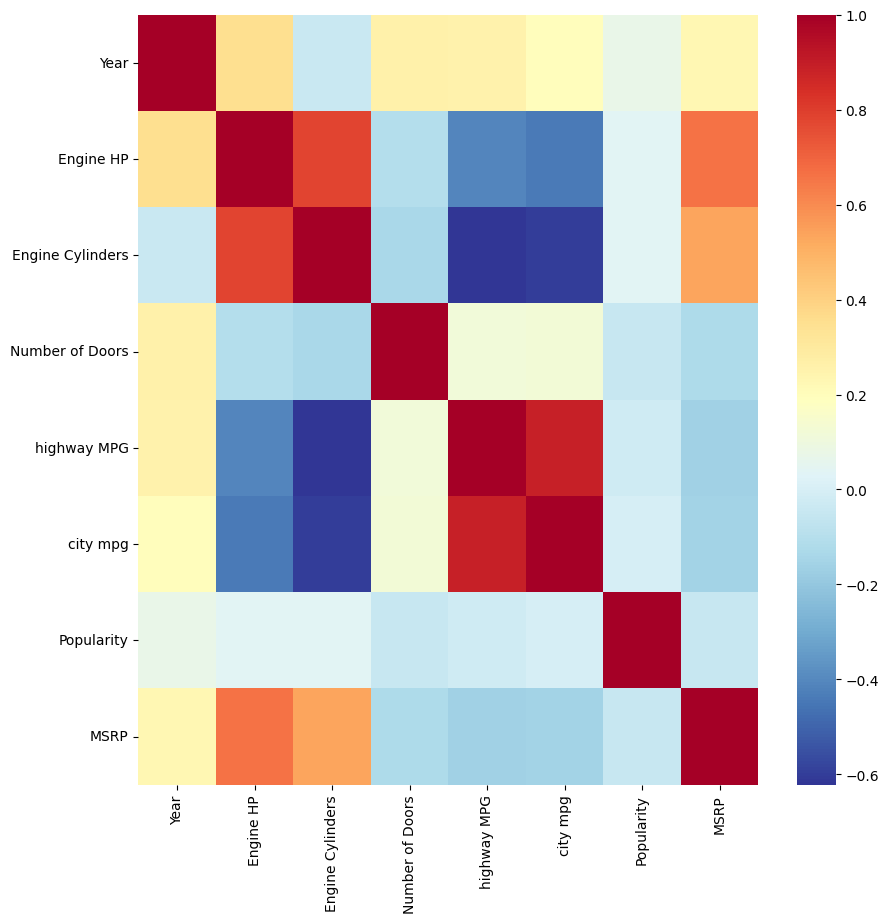

In [ ]:
num_data2 = df.select_dtypes(exclude='object')
plt.figure(figsize=(10, 10))
sns.heatmap(num_data2.corr(), cmap="RdYlBu_r")
plt.show()
#Данный график показывает переменные с корреляциями, который может помочь с выбором для обучения данных

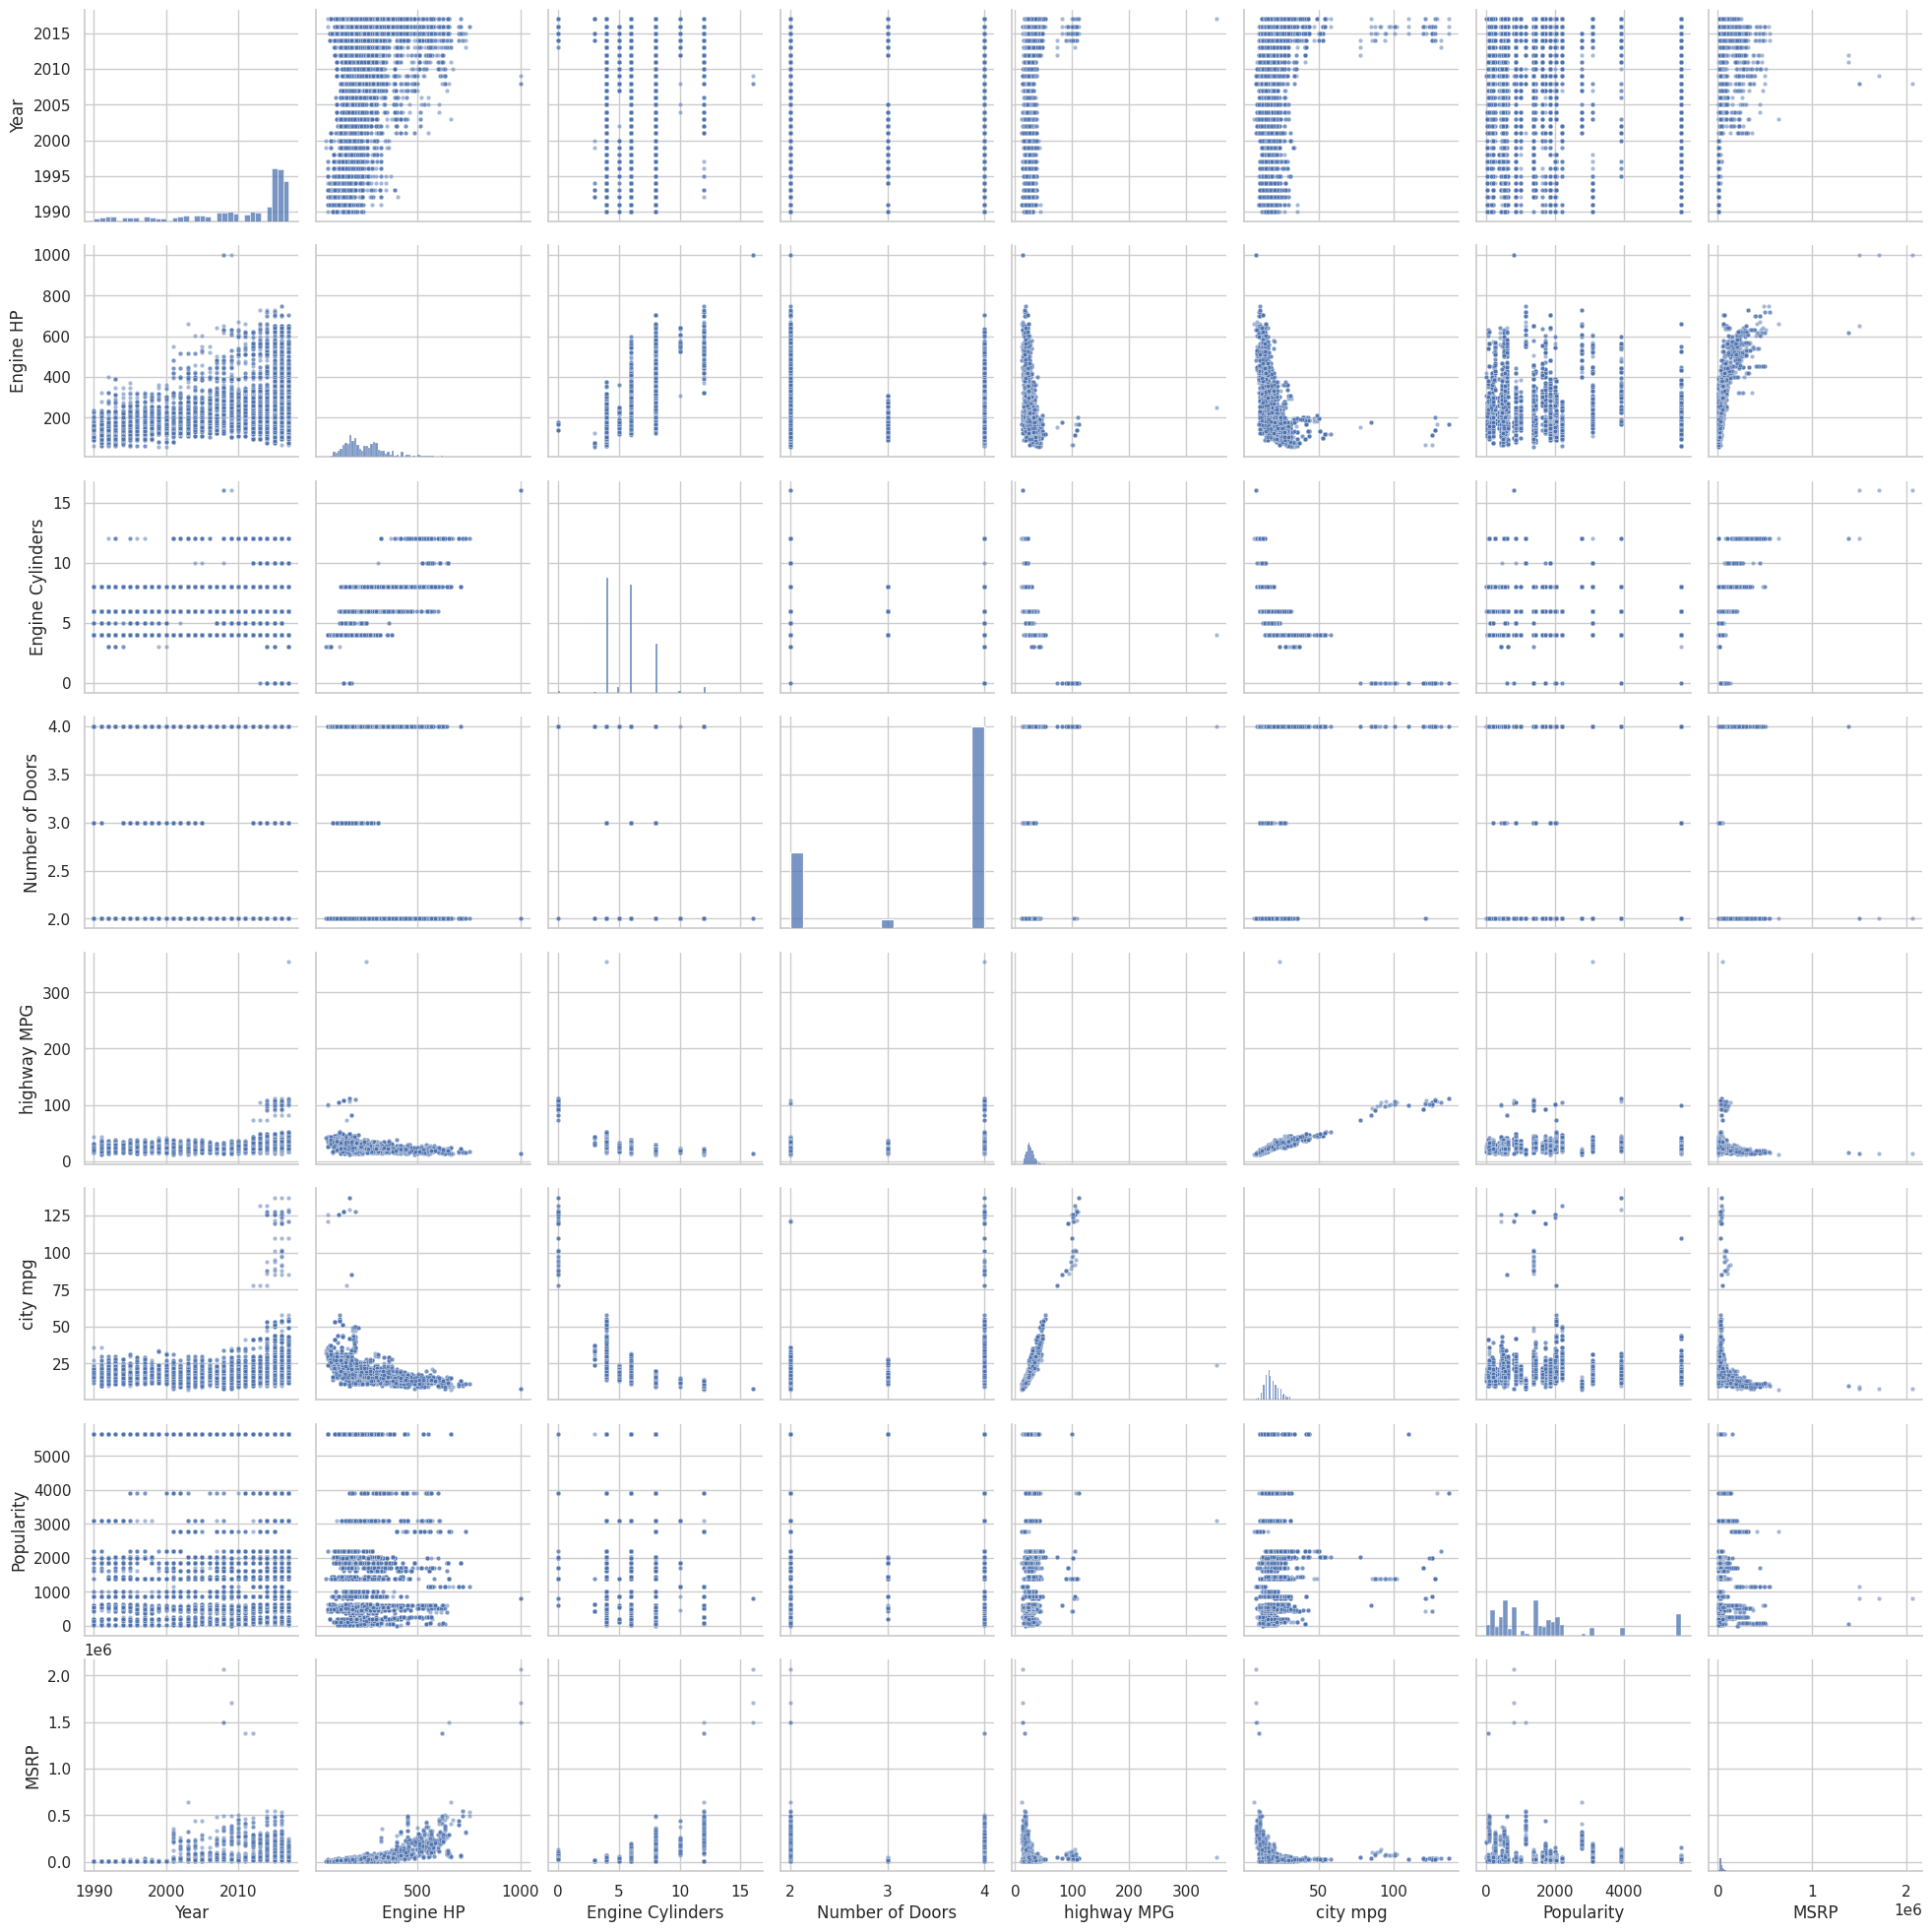

In [5]:
sns.set(style='whitegrid')
sns.pairplot(df, plot_kws={'s': 10,'alpha': 0.5})
plt.suptitle('', y=1.02, fontsize=16)
plt.show()

In [ ]:
fig3 = px.sunburst(
    df,
    labels = ['Price', 'City MPG'],
    path =['city mpg', "Popularity"],
    values = "MSRP",
    #textinfo ='Популярность в зависимости от расхода в городе'
)
fig3.show()

In [6]:
df.drop(['Model', 'Market Category', 'Vehicle Size'], axis=1, inplace=True)
# print(df.columns)
# print(df.head(5))
df = df.rename(columns={'Engine Fuel Type': 'Engine_Fuel_Type',
                   "Engine HP": "Engine_HP",
                   "Engine Cylinders": "Engine_Cylinders",
                   "Transmission Type": "Transmission_Type",
                   "Number of Doors": "Number_of_Doors",
                   "Vehicle Style": "Vehicle_Style",
                   "highway MPG": "Highway_MPG",
                   'city mpg': 'City_MPG'})#Здесь происходит обработка названий колонок для читабельного вида без пробелов
print(df.columns)
print(df.head(5))
# print(df.isna().sum())
# print(df.describe())
# print(df.duplicated())
print(df.dtypes)
print(df["Engine_HP"].isnull().sum())#В предыдущем пункте было показано, что в значениях столбцов мощности и количества цилиндров есть пропуски, которые необходимо заполнить
#В случае с мощностью используется метод заполнения средними значениями, т.к. они пропущены, а в столбце с цилиндрами - выбрано заполнение нулями так как эти данные не представлены для машин с электромоторами, у которых нет цилиндров

df["Engine_HP"] = df["Engine_HP"].fillna(df["Engine_HP"].mean())
df['Engine_Cylinders']= df['Engine_Cylinders'].fillna(0)
df.isna().sum()
# print(df["Make"].unique())

Index(['Make', 'Year', 'Engine_Fuel_Type', 'Engine_HP', 'Engine_Cylinders',
       'Transmission_Type', 'Driven_Wheels', 'Number_of_Doors',
       'Vehicle_Style', 'Highway_MPG', 'City_MPG', 'Popularity', 'MSRP'],
      dtype='object')
  Make  Year             Engine_Fuel_Type  Engine_HP  Engine_Cylinders  \
0  BMW  2011  premium unleaded (required)      335.0               6.0   
1  BMW  2011  premium unleaded (required)      300.0               6.0   
2  BMW  2011  premium unleaded (required)      300.0               6.0   
3  BMW  2011  premium unleaded (required)      230.0               6.0   
4  BMW  2011  premium unleaded (required)      230.0               6.0   

  Transmission_Type     Driven_Wheels  Number_of_Doors Vehicle_Style  \
0            MANUAL  rear wheel drive              2.0         Coupe   
1            MANUAL  rear wheel drive              2.0   Convertible   
2            MANUAL  rear wheel drive              2.0         Coupe   
3            MANUAL  rear wheel

Make                 0
Year                 0
Engine_Fuel_Type     3
Engine_HP            0
Engine_Cylinders     0
Transmission_Type    0
Driven_Wheels        0
Number_of_Doors      6
Vehicle_Style        0
Highway_MPG          0
City_MPG             0
Popularity           0
MSRP                 0
dtype: int64

In [7]:
columns_to_encode = ['Make', 'Engine_Fuel_Type', 'Transmission_Type', 'Driven_Wheels', 'Vehicle_Style']
#num_data = df.select_dtypes(exclude='object')

#le = LabelEncoder()

#for column in columns_to_encode:
    #df[column] = ohe.fit(df[column])

ohe = OneHotEncoder(sparse_output=False)


for column in columns_to_encode:

    column_data = df[[column]]


    encoded_data = ohe.fit_transform(column_data)


    new_columns = [f'{column}_{category}' for category in ohe.get_feature_names_out([column])]


    encoded_df = pd.DataFrame(encoded_data, columns=new_columns)


    df = pd.concat([df, encoded_df], axis=1)


df = df.drop(columns=columns_to_encode)
#Для использования данных о марке машины и не только их необходимо перевести в числовой вид, чтобы можно было использовать в модели

(11914, 92)
Index(['Year', 'Engine_HP', 'Engine_Cylinders', 'Number_of_Doors',
       'Highway_MPG', 'City_MPG', 'Popularity', 'MSRP', 'Make_Make_Acura',
       'Make_Make_Alfa Romeo', 'Make_Make_Aston Martin', 'Make_Make_Audi',
       'Make_Make_BMW', 'Make_Make_Bentley', 'Make_Make_Bugatti',
       'Make_Make_Buick', 'Make_Make_Cadillac', 'Make_Make_Chevrolet',
       'Make_Make_Chrysler', 'Make_Make_Dodge', 'Make_Make_FIAT',
       'Make_Make_Ferrari', 'Make_Make_Ford', 'Make_Make_GMC',
       'Make_Make_Genesis', 'Make_Make_HUMMER', 'Make_Make_Honda',
       'Make_Make_Hyundai', 'Make_Make_Infiniti', 'Make_Make_Kia',
       'Make_Make_Lamborghini', 'Make_Make_Land Rover', 'Make_Make_Lexus',
       'Make_Make_Lincoln', 'Make_Make_Lotus', 'Make_Make_Maserati',
       'Make_Make_Maybach', 'Make_Make_Mazda', 'Make_Make_McLaren',
       'Make_Make_Mercedes-Benz', 'Make_Make_Mitsubishi', 'Make_Make_Nissan',
       'Make_Make_Oldsmobile', 'Make_Make_Plymouth', 'Make_Make_Pontiac',
       

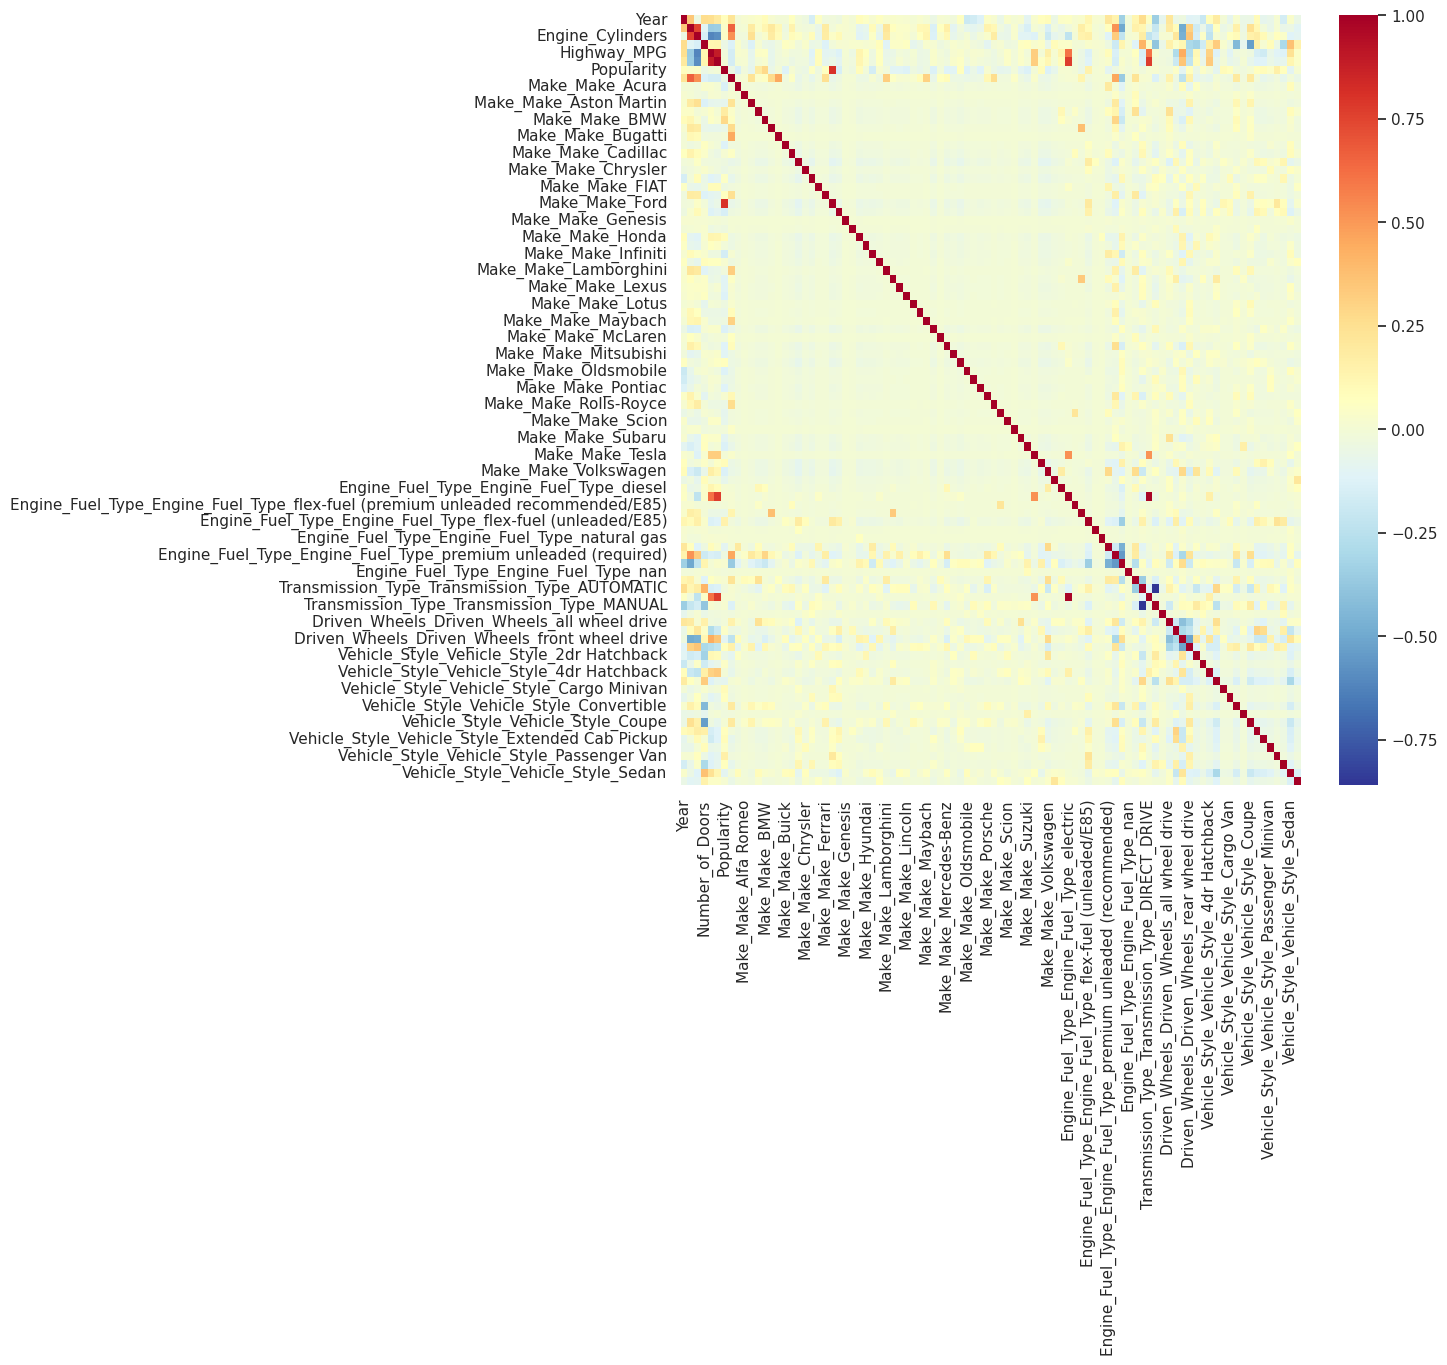

In [8]:
#df = df.drop(columns=columns_to_encode)
#print(df.head(5))
num_data = df.select_dtypes(exclude='object')
print(num_data.shape)
print(num_data.columns)
df
#print(num_data.head())

plt.figure(figsize=(10, 10))
sns.heatmap(num_data.corr(), cmap="RdYlBu_r")
plt.show()
# cat_data = df.select_dtypes(include='object')
# print(cat_data.shape)
# print(cat_data.head())

In [9]:
print (df.head(5))
df['Engine_Cylinders'].fillna(0)
df['Engine_Cylinders'].isna()
df['Engine_HP'].fillna(0)
df['Engine_HP'].isna().sum()

   Year  Engine_HP  Engine_Cylinders  Number_of_Doors  Highway_MPG  City_MPG  \
0  2011      335.0               6.0              2.0           26        19   
1  2011      300.0               6.0              2.0           28        19   
2  2011      300.0               6.0              2.0           28        20   
3  2011      230.0               6.0              2.0           28        18   
4  2011      230.0               6.0              2.0           28        18   

   Popularity   MSRP  Make_Make_Acura  Make_Make_Alfa Romeo  ...  \
0        3916  46135              0.0                   0.0  ...   
1        3916  40650              0.0                   0.0  ...   
2        3916  36350              0.0                   0.0  ...   
3        3916  29450              0.0                   0.0  ...   
4        3916  34500              0.0                   0.0  ...   

   Vehicle_Style_Vehicle_Style_Convertible  \
0                                      0.0   
1                 

0

In [10]:


split = ShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, test_index in split.split(df, df[[ "Engine_HP", "Engine_Cylinders",'Highway_MPG',"City_MPG", "Popularity","MSRP"]]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
X_train = strat_train_set[['Highway_MPG', "City_MPG", "MSRP", "Engine_HP", "Engine_Cylinders"]]
X_test = strat_test_set[['Highway_MPG', "City_MPG", "MSRP", "Engine_HP", "Engine_Cylinders"]]
Y_train = strat_train_set['Popularity']
Y_test = strat_test_set['Popularity']
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, Y_train)
Y_pred_clf = clf.predict(X_test)

In [11]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, Y_train)
Y_pred_dummy = dummy_clf.predict(X_test)
# print(f'Recall for Logistic regression: {recall_score(Y_test, Y_pred_clf, average ="micro")}')
# print(f'Precision for Descision Tree: {precision_score(Y_test, Y_pred_clf, average ="micro")}')
print(f'F1-score for Descision Tree: {f1_score(Y_test, Y_pred_clf, average ="micro")}')
print(f'F1-score for Dummy: {f1_score(Y_test, Y_pred_dummy, average ="micro")}')

F1-score for Descision Tree: 0.8197381671701913
F1-score for Dummy: 0.09466263846928501
